# Der eindimensionale Kalman-Filter, Teil 1 Grundlagen
4.11.2019, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Was bisher geschah:
1. In den ersten beiden Notebooks wurde der g-h-Filter behandelt. Mit ihm wurde der auch f√ºr den Kalman-Filter grundlegende Filteralgorithmus in Form der Iteration aus Vorhersage und Korrektur eingef√ºhrt.  
2. In den beiden Notebooks zum diskreten Bayes-Filter wurde die Bayes-Wahrscheinlichkeitsrechnung eingef√ºhrt. Zudem wurden die mathematischen Rechenwege der Filteriteration entwickelt: Die Faltung f√ºr die Vorhersage und die elementweise Vektormultiplikation f√ºr die Korrektur.  
3. Im Notebook zur Gau√üschen Wahrscheinlichkeitsrechnung wurde aus der diskreten, multimodalen Bayes-Welt in die unimodale, kontinuierliche Gau√ü-Welt gewechselt: F√ºr eine typische Filteraufgabe von Sensormesswerten ist die Gau√üsche Wahrscheinlichkeitsrechnung besser geeignet. Die wesentlichen Eigenschaften von Gau√üverteilungen sowie grundlegende Rechenvorschriften dazu wurden vorgestellt.  

> Nun ist es soweit, den **Bayes-Filter mit Gau√üverteilungen zu kombinieren**: Nichts Anderes ist ein Kalman-Filter.

In diesem Teil wird ausschlie√ülich der eindimensionale Kalman-Filter behandelt: Es geht dabei nur um *eine* einzelne Zustandsgr√∂√üe wie z.B. der Abstand, welche "getrackt" oder anders gesagt "gefiltert" werden soll.

## Gedankenexperiment

Genau so wie im Kapitel zum Bayes-Filter soll die Position eines Roboterfahrzeugs in einem langen, dieses Mal geraden Flur "getrackt" werden. Nur gibt es jetzt keine T√ºrsensoren und auch keinen Bewegungssensor.   
Die Position des Fahrzeugs im Flur wird √ºber einen Abstandssensor gemessen. Da der Flur gerade ist, wird beispielsweise ein Lidarsensor am Anfang des Flurs platziert, der das Roboterfahrzeug antastet und so dessen Position misst.  

Dieser Abstandssensor besitzt eine zuf√§llige Messunsicherheit. Die Messwerte streuen gau√üf√∂rmig um den wahren Wert.

### Annahme als Gau√üverteilung

Anders als beim Bayes-Filter ist die Annahme der Fahrzeugposition nicht mehr ein Histogramm. Die angenommene Fahrzeugposition ist jetzt eine Gau√üverteilung.  
**Beispiel:** Angenommen, das Fahrzeug befindet sich in einem Abstand von 10 m. Diese Annahme hat aber eine Unsicherheit von $\pm$ 1 m bezogen auf ein Vertrauensniveau von 68 %.  Dies hei√üt nichts Anderes, dass die Wahrscheinlichkeitsverteilung des Fahrzeugabstands eine Gau√üverteilung mit Erwartungswert 10 m und Varianz 1 m¬≤ ist: Mathematisch wird diese unsichere Position √ºber $\mathcal{N}(10,\, 1)$ ausgedr√ºckt. Die entsprechende Wahrscheinlichkeitsverteilung ist in folgendem Plot dargestellt:

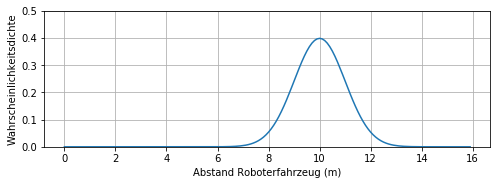

In [2]:
from scipy.stats import norm
x = np.arange(0,16,0.1)
mu = 10
sigma = 1
pdf_gauss = norm.pdf(x,mu,sigma)

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x,pdf_gauss)
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.set_ylim(0,0.5)
ax.grid()

Im n√§chsten Plot sind 500 simulierte Abstandsmesswerte f√ºr  $\mathcal N(10, 1)$ dargestellt. So w√ºrde eine Abfolge von Sensormessdaten aussehen, falls das Fahrzeug bewegungslos an der Position 10 m steht:

Mittelwert Abstandsmesswerte 9.979


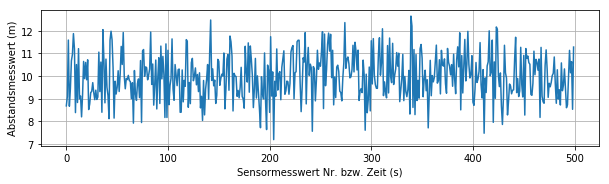

In [3]:
#from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = np.random.randn(500)*1. + 10.
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(xs, ys)
ax.set_xlabel('Sensormesswert Nr. bzw. Zeit (s)')
ax.set_ylabel('Abstandsmesswert (m)')
ax.grid()
print('Mittelwert Abstandsmesswerte {:.3f}'.format(np.mean(ys)))

Betrachtet man den zeitlichen Verlauf der Abstandsmessdaten mit gesundem Menschenverstand, so ist sofort klar, dass die Streuung nicht einer tats√§chlichen Bewegung des Fahrzeugs entspricht - selbst wenn man nicht wei√ü, dass es still steht. D.h. das physikalische Modell des Fahrzeugs, welches hier nur in unserer Intuition existiert,  passt nicht zu den Messdaten. Daher w√ºrde ein Filter mit gutem physikalischen Modell hier behaupten, das Fahrzeug befinde sich genau bei 10 m Abstand mit eine Unsicherheit weit kleiner als 1 m.

## Vergleich Tracking mit Gau√üschen und Bayesschen Wahrscheinlichkeitsverteilungen

Der (diskrete) Bayes-Filter verwendet ein Histogramm, um das Fahrzeug zu tracken. Jede S√§ule des Histogramms entspricht einem (diskreten) Abstandswert. Die S√§ulenh√∂he gibt die Wahrscheinlichkeit an, das Fahrzeug dort zu finden.

Das Tracking aktualisiert dieses Histogramm, indem Iterationen aus Vorhersagen mit anschlie√üenden Korrekturen durchgef√ºhrt werden. Dazu wurden im Notebook zum Bayes-Filter folgende Grundgleichungen aufgestellt:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf {\hat x} \ast f_{\mathbf x}\, \, &\text{Vorhersageschritt} \\ 
\mathbf {\hat x} &= \|\mathcal L \circ \bar{\mathbf x}\|\, \, &\text{Korrekturschritt} \end{aligned}$$

Den Vorhersagewert $\bar{\mathbf x}$ nennt man auch *Prior*, den Korrektur- oder Sch√§tzwert $\hat{\mathbf x}$ nennt man auch *Posterior*.  
$\mathcal L$ ist die *Likelihood* basierend auf einer Messung, in $f_{\mathbf x}$ steckt das *Prozessmodel*, $\ast$ bedeutet *Faltung* und $\circ$ steht f√ºr eine *elementweise Multiplikation*. $\mathbf x$ ist der Vektor, der die Histogrammwerte enth√§lt, seine Elemente entsprechen der H√∂he der Histogramms√§ulen.

Dieser Algorithmus des Bayes-Filters funktioniert gut, wie im letzten Notebook gezeigt. Er ist aber sehr rechenaufw√§ndig und leider diskret.  
Das Ziel des vorliegenden Notebooks ist es, das Histogramm $\mathbf x$ mit einer Gau√üverteilung $\mathcal N(x, \sigma^2)$ zu ersetzen und den gleichen Filteralgorithmus wie bei der Bayes-Verteilung damit durchzuf√ºhren.  
Dieses Vorhaben ist nicht abwegig, wie folgender Plot zeigt: Ist n√§mlich das Histogramm in etwa gau√üf√∂rmig, dann kann man es n√§herungsweise durch die beiden Parameter $\mu$ und $\sigma^2$ der Gau√üverteilung ersetzen: Diese zwei Parameter ersetzen somit Hunderte Array-Elemente der Histogramme, was erheblich Rechenzeit und Speicherplatz spart.

[]

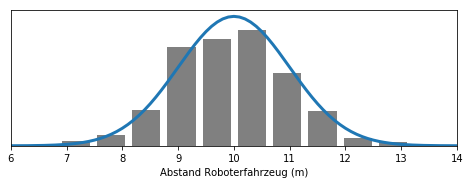

In [4]:
np.random.seed(12) # get allways same random number sequence
xs = range(500)
ys = np.random.randn(500)*1. + 10.
fig, ax = plt.subplots(figsize=(8,2.5))
ax.hist(ys, histtype='bar', color='grey', rwidth=0.8)
ax.plot(x,330*pdf_gauss, lw='3')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_xlim(6,14)
ax.set_yticks([], [])

Folgende Tabelle fasst zusammen, wie die Histogramme des Bayes-Filters durch Gau√üverteilungen des Kalman-Filters ersetzt werden:

$$\begin{array}{l|l|c}
\text{Bayes-Filter} & \text{Kalman-Filter} & \text{Iterationsschritt}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f_x & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}} &
\text{Vorhersage} \\
\mathbf x = \|\mathcal L \circ \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Korrektur} 
\end{array}$$

Die beiden Operatoren $\oplus$ und $\otimes$ sind Platzhalter und stehen f√ºr noch unbekannte Recheoperationen mit Gau√üverteilungen. Der Index ${}_\mathcal{N}$ bei $x_\mathcal{N}$ soll daran erinnern, dass es sich hier um Gau√üverteilungen handelt.

In den folgenden beiden Abschnitten wird nun gezeigt, dass einfache Additionen bzw. Multiplikationen f√ºr die noch unbekannten Operatoren $\oplus$ und $\otimes$ verwendet werden k√∂nnen.

## Vorhersage mit Gau√üverteilung

Als physikalische Modell im Hintergrund (Prozessmodell) wird eine gleichf√∂rmige Bewegung mit der Geschwindigkeit $v_k$ gew√§hlt. Somit gilt f√ºr den Vorhersagewert:

$$ \begin{aligned}\bar{x}_k &= \hat{x}_{k-1} + v_k \Delta t \\
 &= \hat{x}_{k-1} + f_x\end{aligned}$$

Die Propagationsfunktion $f_x$ ist also hier lediglich $v_k \Delta t$. Sie berechnet die zur√ºck gelegte Strecke w√§hrend der Zeit $\Delta t$. 

**Beispiel:** Angenommen, es gibt keine Unsicherheiten in der Position oder in der Geschwindigkeit des Fahrzeugs. Das Fahrzeug sei an der Position 10 m und habe die Geschwindigkeit  15 m/s. Nach einer Zeit $\Delta t$ = 1 s errechnet sich die neue Fahrzeugposition zu:

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 1\\
\bar{x}_k &= 10 + (15\cdot 1) = 25 \end{aligned}$$

Die Herausforderung ist es jetzt, in die Mathematik die Unsicherheit der aktuellen Position und die Unsicherheit der Geschwindigkeit einflie√üen zu lassen.  
Angenommen, die aktuelle Position 10 m ist mit einer Unsicherheit von 0,2 m (68 % Vertrauensniveau) bekannt. Dann kann die Position einfach als Gau√üverteilung $x=\mathcal N(10, 0.2^2)$ angegeben werden. Sozusagen "All Inclusive".  

Es ist naheliegend, auch **die Geschwindigkeit als Gau√üverteilung anzunehmen und diese f√ºr eine Vorhersage auf die Gau√üverteilung der Position auf zu addieren**. Die Mathematik dahinter ist die selbe, wie beispielsweise die der Fehlerfortpfllanzung bei der Addition zweier rauschbehafteter Str√∂me. Dieses Vorgehen macht also Sinn.   

Angenommen, die Geschwindigkeit besitzt eine Unsicherheit von 0.7 m/s (68 % Vertrauensniveau), d.h. $f_x = \mathcal N (15, 0.7^2)$. Dann gilt f√ºr den Vorhersagewert $\bar{x}_k$:

$$\bar{x}_k = \hat{x}_{k-1} + \Delta t f_x = \mathcal N(10, 0.2^2) + \Delta t \mathcal N (15, 0.7^2)$$

Der Einfachheit halber wird wieder angenommen $\Delta t = 1$, wodurch sich die obige Gleichung vereinfacht auf:

$$\bar{x}_k = \hat{x}_{k-1} + f_x = \mathcal N(10, 0.2^2) + \mathcal N (15, 0.7^2)$$

Auf der rechten Seite der Gleichung oben steht eine Addition zweier Gau√üverteilung. Also ist auch die linke Seite wieder eine Gau√üverteilung! 
> Die Vorhersage entspricht einer Addition einer Gau√üverteilung. Damit ist der Vorhersagewert wieder eine Gau√üverteilung. Weitere Iterationsschritte m√ºssen ebenfalls wieder Gau√üverteilungen als Ergebnis liefern. Nur dann ist eine stabile Filteriteration m√∂glich, denn die Berechnungen basieren auf Gau√ü-Wahrscheinlichkeiten.

Allgemein gilt f√ºr den Erwartungswert und die Varianz der Summe aus zwei Gau√üverteilungen:

$$\mu = \mu_1 + \mu_2  \qquad  \sigma^2 = \sigma^2_1 + \sigma^2_2$$

Wie erwartet wird die Varianz durch die Vorhersage etwas gr√∂√üer - genau so wie die Streubreite des Bayes-Filters durch die Faltung. In dem hier betrachteten Beispiel gilt also konkret:


$$\bar x = \mu_{\hat x} + \mu_{f_x} = 10 + 15 = 25 \qquad \bar\sigma^2 = \sigma_{\hat x}^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 = 0.53$$

F√ºr die Gau√üverteilungen $X \sim \mathcal N (\mu,\sigma^2)$ wird nachfolgend ein "Named Tuple" mit der Bezeichnung ``gaussian``  in Python definiert, um sp√§ter einfacher mit solchen Werten rechnen zu k√∂nnen.

In [5]:
from collections import namedtuple
gaussian = namedtuple('Gaussverteilung', ['mean', 'var'])
gaussian.__repr__ = lambda s: 'ùí©(Œº={:.3f}, ùúé¬≤={:.3f})'.format(s[0], s[1])

Die Vorhersagefunktion ``predict()`` besitzt die Variablen ``pos`` und ``movement`` als √úbergabewerte. Beide sind Gau√üverteilungen und werden als Tupel ``gaussian`` in der Form ($\mu$, $\sigma^2$) angegeben.  
``predict()`` addiert sowohl den Erwartungswert als auch die Varianz der beiden Eingangsverteilungen und gibt dies als Ausgangsverteilung zur√ºck. Diese Funktion f√ºhrt also den Vorhersageschritt als Addition der beiden Gau√ü-Verteilungen wie oben beschrieben aus.

In [6]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

Nachfolgend ein kurzer Test der neuen Funktion mit den Gau√üverteilungen f√ºr die aktuelle Position und die Geschwindigkeit des Fahrzeugs  $\mathcal N(10, 0.2^2)$ bzw. $\mathcal N (15, 0.7^2)$.

In [7]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

ùí©(Œº=25.000, ùúé¬≤=0.530)

Der Erwartungswert der Position hat sich wie erwartet um 15 auf 25 m erh√∂ht. Die Varianz ist ebenfalls wie erwartet leicht angestiegen.

## Korrektur mit Gau√üverteilung

Der diskrete Bayes-Filter verwendet Histogramme, um eine Positionsannahme des Roboterfahrzeugs auszudr√ºcken. Die im Histogramm hinterlegte Verteilung ist diskret und eventuell multimodal.  
Nun wird von einer unimodalen Verteilung ausgegangen, da die Sensoren Messwerte liefern die gau√üverteilt sind. Somit werden die Histogramme ebenfalls n√§herungsweise eine Gau√üfunktion als H√ºllkurve besitzen.  
**Die Bayes-Histogramme werden also durch Gau√üverteilungen ersetzt.** Nun bleibt noch die Frage, wie mit diesen Gau√üverteilungen der Korrekturschritt durchgef√ºhrt werden kann.  

Im Fall der Histogramme beim Bayes-Filter wurde f√ºr den Korrekturschritt als folgender Python-Code implementiert:

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

Mathematisch ausgedr√ºckt war der Korrekturschritt des Bayes-Filters eine elementweise Multiplikation des Vektors der Aufenthaltswahrscheinlichkeit (Vorhersagewert) mit dem Vektor der Likelyhood.

$$x = \| \mathcal L \circ \bar x \|$$

Der Vorhersagewert $\bar x$ liegt schon als Gau√üverteilung aus dem vorherigen Abschnitt vor. In der Likelyhood $\mathcal L$ steckte beim Bayes-Filter die Information des Sensormesswerts.  
Die statistische Messunsicherheit des Sensors ist nun aber gau√üf√∂rmig. Also liegt es nahe, das Messergebnis $z$ des Sensors auch mit einer Gau√üverteilung auszudr√ºcken.  
**Beispiel:** $z = \mathcal N (24, 0.16)$.
Dies bedeutet: Es liegt ein Messwert von 24 m vor mit einer Unsicherheit von 0,4 m bezogen auf ein Vertrauensniveau von 68 %.
Nun liegen sowohl der Vorhersagewert $\bar x$ als auch der Messwert $z$ als Gau√üverteilungen vor. Es fehlt nur noch die Rechenvorschrift, wie aus diesen beiden Verteilungen der Korrekturwert $\hat x$ berechnet wird.  

Im Notebook zur Gau√ü-Wahrscheinlichkeitsverteilung wurde dargestellt, dass das Produkt zweier Gau√üverteilungen wieder (bis auf die Normierung) eine Gau√üverteilung liefert:   

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Ein genauer Blick auf die Formeln oben zeigt: Die Varianz des Produkts berechnet sich nur aus den Varianzen der Faktoren. Sie ist kleiner als jede der beiden Eingangsvarianzen. Die Erwartungswerte haben darauf keinen Einfluss.  
Der Erwartungswert des Produkts ist ein √ºber die Varianzen gewichteter Mittelwert der Erwartungswerte der beiden Faktoren.  

>Die Multiplikation der beiden Gau√üverteilungen "Vorhersagewert" und "Messwert" macht also genau das, was im Bayes-Filter die Multiplikation $\| \mathcal L \circ \bar x \|$ bewerkstelligte: Es wird ein Korrekturwert damit berechnet, der zwischen dem Vorhersagewert und Messwert liegt und eine kleinere Unsicherheit als jeweils der Vorhersagewert und Messwert alleine besitzt.

Die Mathematik des Korrekturschritts f√ºr Gau√üverteilungen l√§sst sich also wie folgt formulieren:  

$$\begin{aligned}
\mathcal N(\hat \mu, \hat \sigma^2) &=\mathcal{N}(\bar\mu, \bar\sigma^2) \times \mathcal{N}(\mu_z, \sigma_z^2) \\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

Das Multiplikationszeichen $\times$ soll andeuten, dass es sich hier um ein Produkt (also eine Kombination) von Wahrscheinlichkeiten handelt. Das rechnerische Produkt der beiden Gau√ü-Verteilungen muss daher noch normiert werden. Diese Normierung geschieht in der zweiten Zeile dadurch, dass die entsprechenden Werte f√ºr $\mu$ und $\sigma$ eingesetzt werden.  
Diese Rechenvorschrift wird nun in der Funktion ``gaussian_multiply()`` implementiert, womit wiederum eine Funktion ``update()`` erstellt wird, die den Korrekturschritt durchf√ºhrt.

In [8]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelyhood):
    posterior = gaussian_multiply(likelyhood, prior)
    return posterior

pos = gaussian(25., 0.350) # prior
meas = gaussian(24, 0.16) # measurement

update(pos, meas)

ùí©(Œº=24.314, ùúé¬≤=0.110)

Der Test der Funktion ``update()`` am Ende des Codes oben zeigt, dass die Gau√üverteilung des Korrekturwerts eine kleinere Varianz als der Messwert bzw. Vorhersagewert hat. Der Erwartungswert des Korrekturwerts liegt etwa doppelt so nah am Messwert wie am Vorhersagewert. Dies macht Sinn, denn die Varianz des Vorhersagewerts war auch etwa doppelt so gro√ü wie die des Messwerts.

Der Algorithmus der Funktion ``update()`` hat die Aufgabe aus einer Wahrscheinlichkeitsverteilung und einer Messwertverteilung eine neue Wahrscheinlichkeitsverteilung f√ºr die Zustandsgr√∂√üe zu berechnen. Wie schon angesprochen liefert die Multiplikation zweier Gau√üverteilungen und eine anschlie√üende Normierung ein plausibles Ergebnis. Zudem ist die neue Wahrscheinlichkeitsverteilung wieder eine Gau√üverteilung, wodurch dieser Schritt genau so wie der Vorhersageschritt im sp√§teren Kalman-Filter iterativ angewendet werden kann.  

Es bleibt aber noch offen zu beweisen, dass die Multiplikation der beiden Gau√üverteilungen tats√§chlich die statistisch richtige, also wahrscheinlichste Verteilung der Zustandsgr√∂√üe ergibt. Mathematische Beweise sind jedoch langweilig und f√ºr eine Anwendung der Mathematik nicht zwingend n√∂tig. Daher ist es besser, diesen Sachverhalt intuitiv nachvollziehen zu k√∂nnen, womit sich der folgende Abschnitt befasst.

### Multiplikation von Gau√üverteilungen als Korrekturschritt
Dieser Abschnitts hat das Ziel, Folgendes ohne formalen mathematischen Beweis zu zeigen:  
> Es liegen zwei Wahrscheinlichkeitsverteilungen einer Zustandsgr√∂√üe (hier der Abstand) vor. Die erste Verteilung ist die aktuelle Annahme der Zustandsgr√∂√üe (hier der Vorhersagewert aufgrund des physikalischen Modells), die zweite Verteilung ist der Messwert der Zustandsgr√∂√üe (hier der Messwert des Abstandssensors). Die normierte Multiplikation beider Verteilungen ist  die wahrscheinlichste Verteilung der Zustandsgr√∂√üe.  

#### Vorhersagewert und Messwert stimmen √ºberein
Angenommen, der Vorhersagewert stimmt mit dem Messwert √ºberein. Der Korrekturwert berechnet sich dann aus $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Folgender Plot zeigt sowohl die deckungsgleiche Verteilung von Vorhersagewert und Messwert als auch die Verteilung des Korrekturwerts:

ùí©(Œº=10.000, ùúé¬≤=0.500)


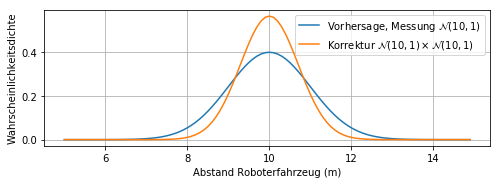

In [9]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)
prior = gaussian(10., 1.)
posterior = gaussian_multiply(z, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x,pdf_prior,label='Vorhersage, Messung $\mathcal{N}(10,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

Der Erwartungswert ist wie erwartet gleich geblieben. Die Varianz hat sich halbiert: Die Varianz eines Mittelwerts sinkt mit 1/N, wobei N f√ºr die Stichprobengr√∂√üe steht. Der Korrekturwert l√§sst sich als Mittelwert aus dem Vorhersagewert und dem Messwert auffassen. Daher macht auch die Halbierung der Varianz im Beispiel oben Sinn.

#### Vorhersagewert und Messwert mit gleicher Varianz aber abweichendem Erwartungswert
Der n√§chste Plot betrachtet die Situation, dass der Vorhersagewert $\mathcal{N}(8,\, 1)$ und der Messwert $\mathcal{N}(12,\, 1)$ einen unterschiedlichen Erwartungswert aber die gleiche Varianz besitzen. Wie erwartet liegt der Korrekturwert genau in der Mitte, denn beide Eingangsverteilungen besitzen die gleiche Unsicherheit. Die Varianz des Korrekturwerts hat sich auch hier aus dem selben Grund wie im Beispiel oben halbiert.

ùí©(Œº=10.000, ùúé¬≤=0.500)


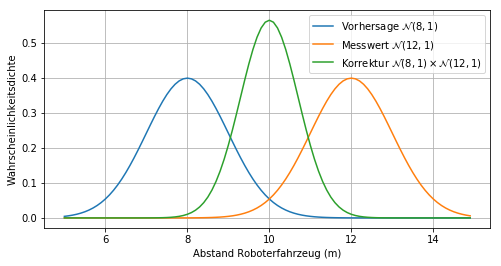

In [10]:
z = gaussian(12, 1)  # Gaussian N(10, 1)
prior = gaussian(8, 1)

posterior = gaussian_multiply(prior, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_z = norm.pdf(x,z.mean,np.sqrt(z.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,pdf_prior,label='Vorhersage $\mathcal{N}(8,1)$')
ax.plot(x,pdf_z,label='Messwert $\mathcal{N}(12,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(8,1) \\times \mathcal{N}(12,1)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

### Vorhersagewert und Messwert mit unterschiedlichem Erwartungswert und deutlich unterschiedlicher Varianz

Die Multiplikation der beiden Gau√üverteilungen liefert also ein entsprechendes Ergebnis wie der g-h-Filter: Der Korrekturwert liegt zwischen dem Vorhersagewert und dem Messwert. Ob er n√§her am Messwert oder n√§her am Vorhersagewert liegt, wird hier im Fall der Gau√üverteilung √ºber das Verh√§ltnis der beiden Varianzen bestimmt.    
Dies wird im nachfolgenden Plot verdeutlicht: Die Vorhersage und der Messwert besitzen die selben unterschiedlichen Erwartungswerte wie im Plot oben, haben jedoch jetzt eine deutlich unterschiedliche Unsicherheit (Varianz).  
Der Korrekturwert ist der nach den beiden Varianzen gewichtete Mittelwert aus der Vorhersage und der Messung. Da die Varianz der Vorhersage dreimal kleiner ist als die der Messung, liegt der Korrekturwert auch dreimal n√§her am Vorhersagewert als an dem Messwert.

ùí©(Œº=9.000, ùúé¬≤=0.375)


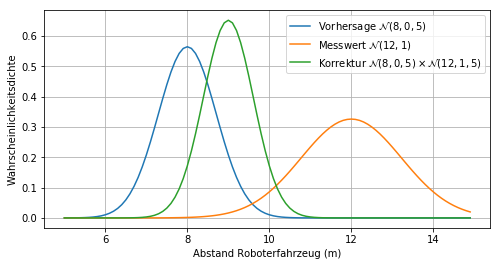

In [11]:
z = gaussian(12, 1.5)  # Gaussian N(10, 1)
prior = gaussian(8, 0.5)

posterior = gaussian_multiply(prior, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_z = norm.pdf(x,z.mean,np.sqrt(z.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,pdf_prior,label='Vorhersage $\mathcal{N}(8,0,5)$')
ax.plot(x,pdf_z,label='Messwert $\mathcal{N}(12,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(8,0,5) \\times \mathcal{N}(12,1,5)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

### Fazit
Die Iteration aus einem Vorhersageschritt und einem Korrekturschritt, wie sie im Notebook f√ºr den g-h-Filter und anschlie√üend f√ºr den Bayes-Filter entwickelt wurde, kann auf gau√üf√∂rmige Wahrscheinlichkeitsverteilungen √ºbertragen werden. Dabei vereinfacht sich die Mathematik erheblich, denn die Vorhersage entspricht einer Addition und die Korrektur einer Multiplikation von Gau√üfunktionen.